# ROSSMAN SALES FORECASTING

This notebook builds a clean, simplified forecasting pipeline using the Rossmann Store Sales dataset.
We:
- Merge train.csv with store.csv
- Filter closed days (Open=0)
- Aggregate sales to monthly total
- Train a Prophet model
- Produce a 12-month forecast
- Save a clean CSV for Power BI

In [13]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    from prophet import Prophet
except:
    from fbprophet import Prophet

### Loading the data
We use:
- train.csv → historical daily sales per store
- store.csv → metadata for stores

In [14]:
train_path = r"C:\Users\jatin\FUTURE_ML_01\data\train.csv"
store_path = r"C:\Users\jatin\FUTURE_ML_01\data\store.csv"

df_train = pd.read_csv(train_path, parse_dates=["Date"])
df_store = pd.read_csv(store_path)

print("Train shape:", df_train.shape)
print("Store shape:", df_store.shape)

# Merge on Store column
df = df_train.merge(df_store, on="Store", how="left")
df.shape


Train shape: (1017209, 9)
Store shape: (1115, 10)


(1017209, 18)

## DATA PREPROCESSING
Basic Cleaning.
We remove:
- Closed days → Open = 0
- NaN sales
- Irrelevant columns for simple forecasting


In [15]:
# Remove closed days and zero-sales days
df = df[(df["Open"] == 1) & (df["Sales"] > 0)]

# Keep only useful columns
df = df[["Date", "Store", "Sales"]]

df = df.sort_values("Date").reset_index(drop=True)
print(df.head())

        Date  Store  Sales
0 2013-01-01   1097   5961
1 2013-01-01     85   4220
2 2013-01-01    259   6851
3 2013-01-01    262  17267
4 2013-01-01    274   3102


### Aggregate to Monthly Sales (Total Across All Stores)

We sum **all stores together** → total retail sales per month.
This is the simplest and most interpretable forecasting target.


In [16]:
df_month = (
    df.set_index("Date")
      .resample("M")["Sales"]
      .sum()
      .reset_index()
      .rename(columns={"Date": "ds", "Sales": "y"})
)

print("Monthly rows:", len(df_month))
df_month.head()


Monthly rows: 31


,ds,y
0,2013-01-31,180132207
1,2013-02-28,171534275
2,2013-03-31,201180369
3,2013-04-30,183431432
4,2013-05-31,185411063


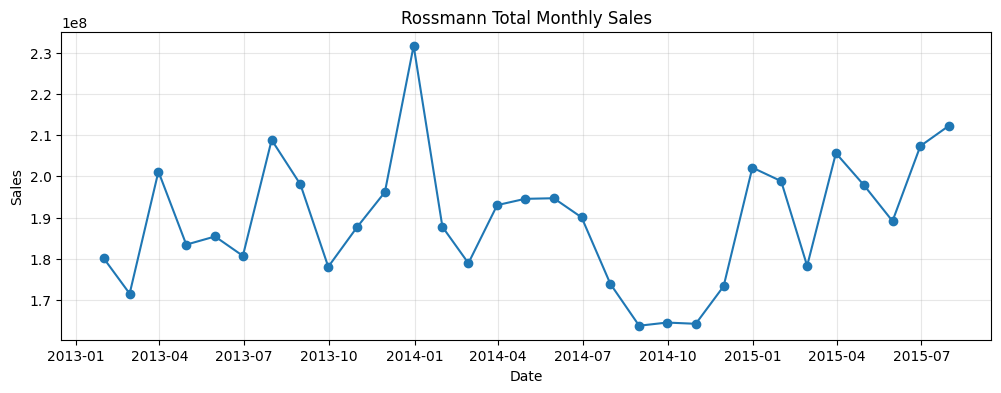

In [17]:
plt.figure(figsize=(12,4))
plt.plot(df_month["ds"], df_month["y"], marker="o")
plt.title("Rossmann Total Monthly Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(alpha=0.3)


### Train / Holdout Split
Use last 6 months as holdout to evaluate.

In [18]:
HOLDOUT = 6
train = df_month.iloc[:-HOLDOUT]
holdout = df_month.iloc[-HOLDOUT:]
len(train), len(holdout)


(25, 6)

## MODEL TRAINING
Fitting Prophet Model


In [19]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(train)

future = m.make_future_dataframe(periods=HOLDOUT + 12, freq="M")
forecast = m.predict(future)

forecast_simple = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]
forecast_simple.tail()


11:17:39 - cmdstanpy - INFO - Chain [1] start processing
11:17:40 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
38,2016-03-31,1.839289e+08,1.743312e+08,1.928532e+08
39,2016-04-30,1.389318e+08,1.282910e+08,1.478700e+08
40,2016-05-31,1.314592e+08,1.197302e+08,1.410583e+08
41,2016-06-30,1.142115e+08,1.021748e+08,1.250448e+08
42,2016-07-31,1.748974e+08,1.615472e+08,1.860808e+08


## EVALUATION

In [21]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

eval_df = holdout.merge(forecast_simple.rename(columns={"yhat":"forecast"}), on="ds", how="left")

y_true = eval_df["y"].values
y_pred = eval_df["forecast"].values

# Calculate MSE first
mse_value = mean_squared_error(y_true, y_pred)

# Calculate RMSE manually using numpy.sqrt()
rmse_value = np.sqrt(mse_value)

print("MAE:", mean_absolute_error(y_true, y_pred))
# Print the manually calculated RMSE
print(f"RMSE: {rmse_value}")


MAE: 34977653.02104405
RMSE: 42483831.59297545


## Prepare Power BI CSV
Columns:
- date
- actual
- forecast
- lower
- upper


In [22]:
actual = df_month.rename(columns={"ds":"date", "y":"actual"})
fcst = forecast_simple.rename(columns={"ds":"date",
                                       "yhat":"forecast",
                                       "yhat_lower":"lower",
                                       "yhat_upper":"upper"})

final = fcst.merge(actual, on="date", how="left")

final.to_csv("../output/forecast_output.csv", index=False)

print("Saved:", "../output/forecast_output.csv")
final.head()

Saved: ../output/forecast_output.csv


,date,forecast,lower,upper,actual
0,2013-01-31,1.758409e+08,1.709655e+08,1.812489e+08,180132207.0
1,2013-02-28,1.751354e+08,1.706358e+08,1.798885e+08,171534275.0
2,2013-03-31,2.050254e+08,2.003555e+08,2.096327e+08,201180369.0
3,2013-04-30,1.866199e+08,1.816893e+08,1.915246e+08,183431432.0
4,2013-05-31,1.871215e+08,1.827790e+08,1.919338e+08,185411063.0


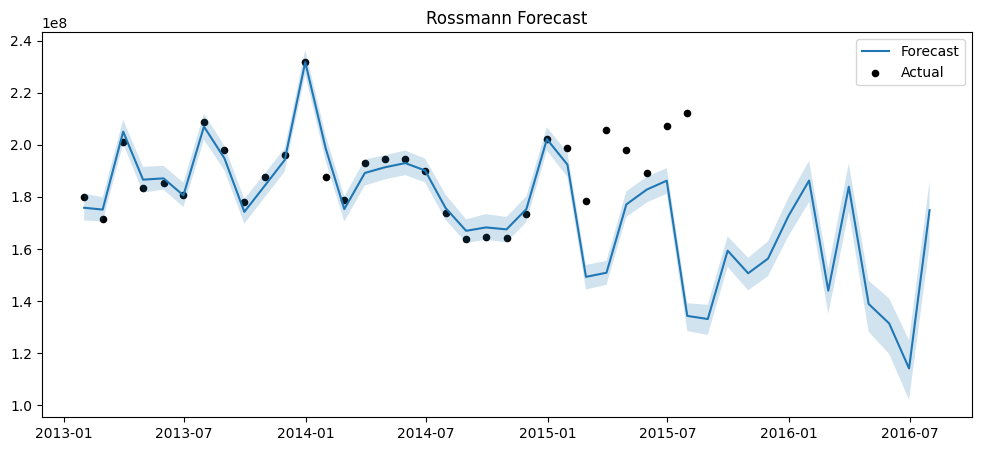

In [23]:
plt.figure(figsize=(12,5))
plt.plot(final["date"], final["forecast"], label="Forecast")
plt.scatter(final["date"], final["actual"], s=20, color="black", label="Actual")
plt.fill_between(final["date"], final["lower"], final["upper"], alpha=0.2)
plt.legend()
plt.title("Rossmann Forecast")
plt.show()


## Next Steps

1. Have to load `forecast_output.csv` into Power BI
2. Then Build line chart:
   - X: date
   - Y: actual, forecast
3. Add shaded interval between lower → upper
4. Add KPI card for "Next Month Forecast"
5. Add seasonality (month-wise) chart
6. Save dashboard to: powerbi/Rossmann_Forecast.pbix